In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import geopandas as gpd

import geodatasets


In [2]:
data =pd.read_excel(r"C:/Users/thean/Documents/DACS/-ACS/Online Retail.xlsx")
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
# InvoiceNo: Mã đơn hàng 
# StockCode: Mã sản phẩm 
# Description: Mô tả sản phẩm 
# Quantity: Số lượng sản phẩm 
# InvoiceDate: Ngày hóa đơn 
# UnitPrice: Giá sản phẩm trên mỗi đơn vị 
# CustomerID: Mã khách hàng 
# Country: Quốc gia của khách hàng

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#Kiểm tra dữ liệu trùng lặp
data.duplicated().sum()
#Xóa dữ liệu trùng lặp
data= data.drop_duplicates()

In [6]:
#Kiểm tra dữ liệu bị thiếu
data.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135037
Country             0
dtype: int64

In [7]:
#Kiểm tra các giá trị thiếu trong cột Description và CustomerID
missing_data = data[['Description','CustomerID']].isnull().sum()
total_rows = data.shape[0]
#Tỷ lệ dữ liệu bị thiếu
missing_pre = (missing_data/total_rows)*100


In [8]:
print(missing_data)
print(missing_pre)

Description      1454
CustomerID     135037
dtype: int64
Description     0.270945
CustomerID     25.163377
dtype: float64


#Nhận xét
- Cột Description có 1454 giá trị bị thiếu, chiếm 0.27% tổng số dữ liệu
    - Có thể xóa các dòng dữ liệu này vì số lượng ít
- Cột CustomerID có 135080 giá trị bị thiếu, chiếm 25.16% tổng số dữ liệu -> Tỷ lệ khá cao
    - Do "CustomerID" là thông tin định danh quan trọng trong bài toán phân khúc khách hàng, việc giữ lại các bản ghi thiếu giá trị này là không hợp lý -> Loại bỏ

In [9]:
#Loại bỏ dữ liệu bị thiếu
data = data.dropna(subset=['Description','CustomerID'])
data.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [10]:
#Thống kê cơ bản về dữ liệu
data.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantity,401604.0,12.183273,-80995.0,2.0,5.0,12.0,80995.0,250.283037
InvoiceDate,401604,2011-07-10 12:08:23.848567552,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:40:00,2011-10-20 11:58:30,2011-12-09 12:50:00,NaN
UnitPrice,401604.0,3.474064,0.0,1.25,1.95,3.75,38970.0,69.764035
CustomerID,401604.0,15281.160818,12346.0,13939.0,15145.0,16784.0,18287.0,1714.006089


# Tóm tắt những thứ cần xử lý trong dữ liệu
- Cột "Quantity": Số lượng sản phẩm.
    -   min (Giá trị nhỏ nhất): -80,995 → Giá trị âm lớn, có thể là giao dịch hoàn trả hoặc lỗi dữ liệu.
    -   max (Giá trị lớn nhất): 80,995 → Giá trị lớn bất thường, có thể là lỗi dữ liệu hoặc giao dịch lớn đặc biệt
- Cột "UnitPrice": Giá sản phẩm.
    -   min (Giá trị nhỏ nhất): 0.0 → Giá trị bằng 0 là bất thường, có thể là lỗi dữ liệu hoặc các sản phẩm khuyến mãi.
    -  max (Giá trị lớn nhất): 38,970 → Giá trị rất lớn, có thể là lỗi dữ liệu hoặc các sản phẩm đặc biệt giá trị cao .

In [11]:
#Lọc các giá trị không phù hợp
data = data[data['Quantity']>0]
data = data[data['UnitPrice']>0]
data = data[data['UnitPrice']<=4]    #Giữ lại các sản phẩm có giá từ 4 đơn vị tiền trở xuống
data = data[data['Quantity']<=24]    #Giữ lại các giao dịch có số lượng sản phẩm dưới hoặc bằng 24

In [12]:
#Kiểm tra lại dữ liệu
data.describe()

,Quantity,InvoiceDate,UnitPrice,CustomerID
count,280621.000000,280621,280621.000000,280621.000000
mean,7.823000,2011-07-12 02:12:33.523934208,1.717749,15330.361641
min,1.000000,2010-12-01 08:26:00,0.001000,12347.000000
25%,2.000000,2011-04-07 12:33:00,0.850000,13994.000000
50%,6.000000,2011-08-02 10:34:00,1.650000,15260.000000
75%,12.000000,2011-10-23 14:28:00,2.100000,16837.000000
max,24.000000,2011-12-09 12:50:00,4.000000,18287.000000
std,6.640176,NaN,0.952423,1713.047719


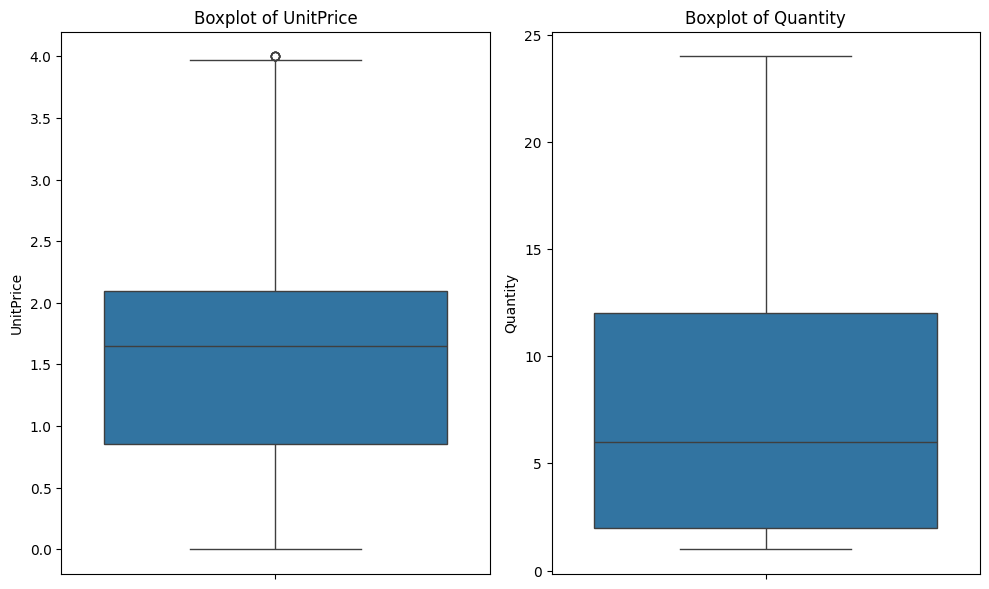

In [13]:
#Trực quan hóa dữ liệu: "UnitPrice vs Quantity"
fig, ax = plt.subplots(1,2,figsize=(10,6))
sns.boxplot(data['UnitPrice'], ax=ax[0])
ax[0].set_title('Boxplot of UnitPrice')
sns.boxplot(data['Quantity'], ax=ax[1])
ax[1].set_title('Boxplot of Quantity')
plt.tight_layout()
plt.show()

#Nhận xét
- Biểu đồ của UnitPrice:
    -   Trung vị khoảng 1.5 - 2, dữ liệu tập trung trong khoảng 1 - 2.5.
    -   Có 1 điểm ngoại lai nhẹ, không nghiêm trọng.
    =>  Dữ liệu đã sạch, ngoại lai có thể giữ lại
- Biểu đồ hộp của Quantity:
    -   Trung vị khoảng 5 - 6, dữ liệu chủ yếu từ 2 - 12.
    -   Không có giá trị ngoại lai.
    =>  Dữ liệu đã được làm sạch tốt

In [14]:
# Định dạng lại cột thời gian và mã khách hàng
data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
data['InvoiceNo'] = data['InvoiceNo'].astype(str)
data['CustomerID'] = data['CustomerID'].astype(str)

In [15]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [16]:
#Tạo cột "TotalPrice" = "Quantity" * "UnitPrice"
data['TotalPrice'] = data['Quantity'] * data['UnitPrice']


In [17]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


Mô hình RFM (Recency - Frequency - Monetary )
Cột TotalPrice: Dùng để tính chỉ số Monetary trong phân tích RFM

In [18]:
#Tạo cột chu kì tháng và năm
data['YearMonth'] = data['InvoiceDate'].dt.to_period('M')

In [19]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [20]:
# YearMonth:
#     -   Xác định tháng nào có doanh thu cao nhất.
#     -   Phát hiện các đợt cao điểm, thấp điểm trong năm.
#     -   Trực quan hóa dữ liệu dạng biểu đồ cột hoặc đường dễ dàng hơn.
#     -   Có thể dùng để tính "Recency" bằng cách so sánh với tháng gần nhất trong dữ liệu.

Xử lý cột Description

In [21]:
# Xóa hàng có giá trị NaN
data.isin(["NaN", "missing", "?", "??"]).any(axis=1).shape[0]

280621

In [22]:
# Đọc các hàng có giá trị NaN
data = data[~data.isin(["NaN", "missing", "?", "??"]).any(axis=1)]

In [23]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...
541900,581587,22730,ALARM CLOCK BAKELIKE IVORY,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00,2011-12
541901,581587,22367,CHILDRENS APRON SPACEBOY DESIGN,8,2011-12-09 12:50:00,1.95,12680.0,France,15.60,2011-12
541902,581587,22629,SPACEBOY LUNCH BOX,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40,2011-12
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12


In [24]:
# Xử lý dữ liệu trong cột
# Kiểm tra số lượng giá trị khác nhau trước và sau khi chuẩn hóa
data["Description"].nunique()
data["Description"].str.lower().str.strip().nunique()
data["Description"] = data["Description"].str.lower().str.strip()

In [25]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [26]:
# Loại bỏ các bản ghi không hợp lệ
invalid_descriptions = [
    "amazon fee", "samples", "postage",
    "packing charge", "manual", "discount",
    "adjust bad debt", "bank charges", "cruk commission",
    "next day carriage"
]
data = data[~data['Description'].isin(invalid_descriptions)]


In [27]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...
541900,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00,2011-12
541901,581587,22367,childrens apron spaceboy design,8,2011-12-09 12:50:00,1.95,12680.0,France,15.60,2011-12
541902,581587,22629,spaceboy lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40,2011-12
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12


- Trong dữ liệu:
    -   1 StockCode (mã sản phẩm) nhưng có nhiều Description khác nhau.
    -   1 Description (mô tả sản phẩm) nhưng có nhiều StockCode khác nhau.
    

In [28]:
# Đồng nhất dữ liệu theo StockCode
for stack_code in data['StockCode'].unique():
    # Lấy mô tả đầu tiên của mỗi mã sản phẩm
    first_description = data[data['StockCode'] == stack_code]['Description'].unique()[0]
    # Gán mô tả đó làm mô tả chuẩn cho toàn bộ các bản ghi cùng mã StockCode
    data.loc[data['StockCode'] == stack_code, 'Description'] = first_description


In [29]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...
541900,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00,2011-12
541901,581587,22367,childrens apron spaceboy design,8,2011-12-09 12:50:00,1.95,12680.0,France,15.60,2011-12
541902,581587,22629,spaceboy lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40,2011-12
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12


In [30]:
# Loại bỏ các bản ghi có Description bị trống hoặc NaN
data = data[~data['Description'].isna()]
data = data[data['Description'].str.strip() != ""]


In [31]:
# Đồng nhất dữ liệu theo Description
for description in data['Description'].unique():
    # Lấy StockCode đầu tiên của mỗi mô tả
    first_code = data[data['Description'] == description]['StockCode'].unique()[0]
    # Gán mã đó làm mã chuẩn cho toàn bộ các bản ghi cùng mô tả
    data.loc[data['Description'] == description, 'StockCode'] = first_code
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
...,...,...,...,...,...,...,...,...,...,...
541900,581587,22730,alarm clock bakelike ivory,4,2011-12-09 12:50:00,3.75,12680.0,France,15.00,2011-12
541901,581587,22367,childrens apron spaceboy design,8,2011-12-09 12:50:00,1.95,12680.0,France,15.60,2011-12
541902,581587,22629,spaceboy lunch box,12,2011-12-09 12:50:00,1.95,12680.0,France,23.40,2011-12
541904,581587,22613,pack of 20 spaceboy napkins,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20,2011-12


In [32]:
# Kiểm tra mỗi mã sản phẩm chỉ có 1 mô tả
print(data.groupby('StockCode')['Description'].nunique().sort_values(ascending=False))

# Kiểm tra mỗi mô tả chỉ có 1 mã sản phẩm
print(data.groupby('Description')['StockCode'].nunique().sort_values(ascending=False))


StockCode
PADS     1
10002    1
10080    1
10120    1
10125    1
        ..
16048    1
16046    1
16043    1
16016    1
16015    1
Name: Description, Length: 2879, dtype: int64
Description
zinc wire sweetheart letter tray      1
10 colour spaceboy pen                1
12 coloured party balloons            1
12 daisy pegs in wood box             1
12 hanging eggs hand painted          1
                                     ..
2 picture book eggs easter bunny      1
2 daisies hair comb                   1
18pc wooden cutlery set disposable    1
15 pink fluffy chicks in box          1
12 red rose peg place settings        1
Name: StockCode, Length: 2879, dtype: int64


- Đảm bảo rằng mỗi mã sản phẩm (StockCode) có một mô tả duy nhất.
-   Đảm bảo rằng mỗi mô tả (Description) chỉ gắn với một mã sản phẩm duy nhất.

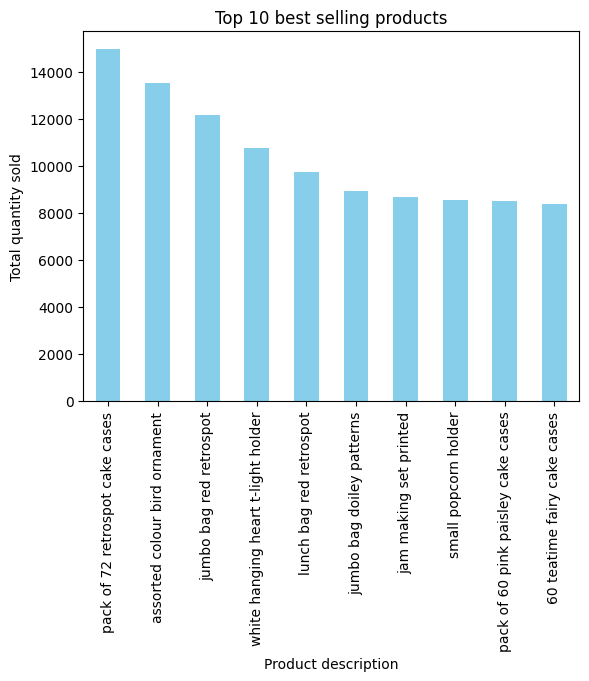

In [33]:
#Sản phẩm bán chạy nhất
best_selling_products = data.groupby('Description')['Quantity'].sum().sort_values(ascending=False)
best_selling_products.head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 best selling products')
plt.ylabel('Total quantity sold')
plt.xlabel('Product description')
plt.show()

In [34]:
# Điền giá trị thiếu bằng 'unknown'
data['Description'].fillna('unknown', inplace=True)
data['Description'].nunique()  # Kiểm tra số lượng sản phẩm duy nhất
data.isnull().sum()            # Kiểm tra giá trị thiếu
data.head()                    # Kiểm tra dữ liệu tổng quan



,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,YearMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12


In [35]:
# Liệt kê các tháng có trong dữ liệu
unique_months = data['YearMonth'].unique()
print(f"Các tháng trong dữ liệu: {unique_months}")


Các tháng trong dữ liệu: <PeriodArray>
['2010-12', '2011-01', '2011-02', '2011-03', '2011-04', '2011-05', '2011-06',
 '2011-07', '2011-08', '2011-09', '2011-10', '2011-11', '2011-12']
Length: 13, dtype: period[M]


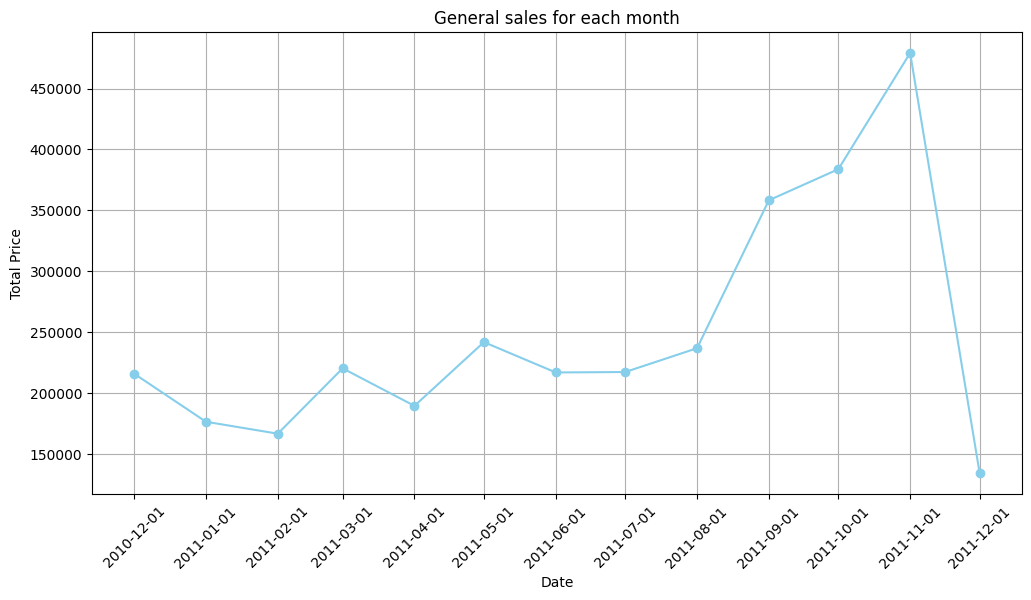

In [36]:
#Doanh thu theo tháng
# Tính tổng doanh thu theo tháng
monthly_revenue = data.groupby('YearMonth')['TotalPrice'].sum()
# Vẽ biểu đồ với dữ liệu đầy đủ tháng
plt.figure(figsize=(12, 6))
plt.plot(monthly_revenue.index.to_timestamp(), monthly_revenue.values, marker='o', color='skyblue')

# Định dạng trục x để hiển thị đầy đủ các tháng
plt.xticks(monthly_revenue.index.to_timestamp(), rotation=45)

# Thêm tiêu đề và nhãn trục
plt.title('General sales for each month')
plt.xlabel('Date')
plt.ylabel('Total Price')

# Hiển thị đường lưới để dễ quan sát
plt.grid(True)

plt.show()




In [37]:
# Lưu data đã qua tiền xử lý vào file Online Retail Cleaned Data.csv
data.to_csv("Online Retail Cleaned Data.csv", index=False)